### Skin Cancer Classification Algorithms
- Utilise CNN to identfiy cases of melanoma from other cases of skin abrassions
- Compare different algorithms and activation functions
- Utlisie ResNet and compare accuracy to own network

In [1]:
import sys
import os
import copy
os.environ['KMP_DUPLICATE_LIB_OK']='True'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import itertools
# some sklearn packages for model analysis
from sklearn.metrics import confusion_matrix

#pytorch specific libraires 
import torch
import torchvision
import torch.nn as nn
from torchvision import models
from torchvision.io import read_image
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms


seed= 299933
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

from tqdm.auto import tqdm

print(f'Python version info: {sys.version}')
print(f'PyTorch version info: {torch.__version__}')
print(f'PyTorch detects a GPU: {torch.cuda.is_available()}')


# variables for location of training and validation data, modify as needed 
train_path = "C:/Users/ldgre/OneDrive/MSc Data Science 23-24/Deep Learning/Assignment/skin_lesion/train"
val_path = "C:/Users/ldgre/OneDrive/MSc Data Science 23-24/Deep Learning/Assignment/skin_lesion/val"
test_path = "C:/Users/ldgre/OneDrive/MSc Data Science 23-24/Deep Learning/Assignment/skin_lesion/test"

Python version info: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
PyTorch version info: 2.2.2+cu121
PyTorch detects a GPU: True


In [2]:
# transforming training data
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])

# transforming test data
test_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform= None, target_transform= None):
                
        self.img_labels = pd.read_csv(annotations_file) # change to appropriate labels file, think it's under /labels
        self.img_dir = img_dir # change to appropriate image files, test and train
        self.transform = transform
        self.target_tarnsform = target_transform
    
    def __len__(self):
        return len(self.image_labels)   
    

    def __getitem__(self, index):
        img_path= os.path.join(self.img_dir, self.img_labels.iloc[index, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[index, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_tarnsform:
            label = self.target_tarnsform(label)
        return image, label

In [4]:

train_data = datasets.ImageFolder( train_path, transform= train_transform)
test_data = datasets.ImageFolder(test_path, transform= test_transform) 
val_data = datasets.ImageFolder(val_path, transform=test_transform)

# Define the desired ratio for train and evaluation data (e.g., 80% train, 20% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_data))
val_size = len(train_data) - train_size

train_subset, val_subset = random_split(train_data, [train_size, val_size])

print(f'Original training is len {len(train_data)}')
print(f'Train is len {len(train_subset)}')
print(f'Validiation set is len {len(val_subset)}') 
print(f'Test data set is len {len(test_data)}') # use this as a test set 


Original training is len 7848
Train is len 7063
Validiation set is len 785
Test data set is len 600


In [5]:
batch_size = 32

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


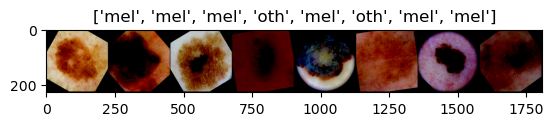

In [6]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['mel', 'oth'] # mel = melanoma, oth = other

imshow(out, title=[class_names[x] for x in classes])

In [15]:
# Convolutional Neural Network, with ReLU activation functions
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3,64,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2,0),

            nn.Conv2d(64,128,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2,0),

            nn.Conv2d(128,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(4,4,0) 
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # input is tensor shape before flatten, in this case 256 * 14 * 14 
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
            # extract features by convolutional layers
            x = self.cnn_layers(x)
            # flatten those features
            x = x.flatten(1)
            # pass the flattened features to the fully connected layers
            x = self.fc_layers(x)
            return x 
    
device = "cuda" if torch.cuda.is_available() else "cpu"



In [34]:
# comment out the line to switch models
#model = CNN()
model = models.resnet18(pretrained = True)
model = model.to(device) # send to gpu

C:\Users\ldgre\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ldgre\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ldgre/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.19MB/s]


### Definine optimisers

In [37]:
criterion = nn.CrossEntropyLoss()
#optimiser = torch.optim.Adam(params= model.parameters(),lr= 0.0005)
#optimiser = torch.optim.SGD(params = model.parameters(), lr= 0.0005, momentum= 0.9)
optimiser = torch.optim.Adadelta(params = model.parameters(), lr=0.0005, weight_decay=0.01)

In [38]:

n_epochs = 60

best_valid_acc =0 
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []
patience = 10
best_valid_loss = float("inf")
best_model_weights = None


for epoch in range(n_epochs):
    model.train()
    train_loss = []
    train_accs = []
    
# iterate over the training set in batches
    for batch in tqdm(train_loader):
        # clear gradients
        optimiser.zero_grad()
# batches contain image data and labels
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
# forward the data
        logits = model(imgs)
# calculate cross-entropy loss
        loss = criterion(logits, labels)
        loss.backward()
# update parameters
        optimiser.step()
# compute accuracy of current batch
        acc= (logits.argmax(dim=-1)== labels).float().mean()
# record loss and accuracy
        train_loss.append(loss.item())
        train_accs.append(acc.item())


# calcualte averages
    train_loss= sum(train_loss)/len(train_loss)
    train_accs= sum(train_accs)/len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_accs)

## validation ##
    model.eval()

    valid_loss = []
    valid_accs = []
    for batch in tqdm(val_loader):
    # batches contain image data and labels
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
             logits=model(imgs)
        loss = criterion(logits, labels)

        acc = (logits.argmax(dim=-1)== labels).float().mean()

        valid_loss.append(loss.item())
        valid_accs.append(acc.item())
    valid_loss= sum(valid_loss)/len(valid_loss)
    valid_accs= sum(valid_accs)/len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_accs)

    # early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_weights = copy.deepcopy(model.state_dict())
        patience=10   
    else:
        patience -= 1
        if patience ==0:
                break    
        
# save the model
    if valid_accs > best_valid_acc:
        best_valid_acc=valid_accs
        torch.save(model.state_dict(), "best_model.pth")
        
# print results 
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f},acc={train_accs:.5f}| Valid: loss={valid_loss:.5f}, acc={valid_accs:.5f}")


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 001/060] Train: loss=8.75228,acc=0.00226| Valid: loss=8.15362, acc=0.00750


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 002/060] Train: loss=7.03718,acc=0.07036| Valid: loss=6.24827, acc=0.14971


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 003/060] Train: loss=5.50360,acc=0.26504| Valid: loss=4.79670, acc=0.39368


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 004/060] Train: loss=4.25453,acc=0.49571| Valid: loss=3.68859, acc=0.59088


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 005/060] Train: loss=3.36579,acc=0.64486| Valid: loss=3.04396, acc=0.68934


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 006/060] Train: loss=2.81549,acc=0.71601| Valid: loss=2.49776, acc=0.74324


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 007/060] Train: loss=2.42663,acc=0.74950| Valid: loss=2.06523, acc=0.78309


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 008/060] Train: loss=2.08304,acc=0.77039| Valid: loss=1.83582, acc=0.78338


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 009/060] Train: loss=1.81775,acc=0.78375| Valid: loss=1.68834, acc=0.78574


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 010/060] Train: loss=1.64761,acc=0.78714| Valid: loss=1.44945, acc=0.79919


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 011/060] Train: loss=1.46935,acc=0.78815| Valid: loss=1.33531, acc=0.79919


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 012/060] Train: loss=1.32728,acc=0.79557| Valid: loss=1.24125, acc=0.78750


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 013/060] Train: loss=1.21244,acc=0.79528| Valid: loss=1.13923, acc=0.78588


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 014/060] Train: loss=1.13236,acc=0.79149| Valid: loss=1.04875, acc=0.78574


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 015/060] Train: loss=1.04061,acc=0.79693| Valid: loss=0.92926, acc=0.80250


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 016/060] Train: loss=0.95522,acc=0.80148| Valid: loss=0.91417, acc=0.79338


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 017/060] Train: loss=0.89384,acc=0.80108| Valid: loss=0.82534, acc=0.80074


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 018/060] Train: loss=0.86655,acc=0.79701| Valid: loss=0.76114, acc=0.79809


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 019/060] Train: loss=0.81463,acc=0.80498| Valid: loss=0.74625, acc=0.81140


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 020/060] Train: loss=0.77939,acc=0.79939| Valid: loss=0.73432, acc=0.80074


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 021/060] Train: loss=0.74063,acc=0.80371| Valid: loss=0.67240, acc=0.80794


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 022/060] Train: loss=0.69841,acc=0.80176| Valid: loss=0.64690, acc=0.80824


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 023/060] Train: loss=0.67973,acc=0.80874| Valid: loss=0.60566, acc=0.81279


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 024/060] Train: loss=0.64449,acc=0.80922| Valid: loss=0.60016, acc=0.80074


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 025/060] Train: loss=0.62420,acc=0.81493| Valid: loss=0.55192, acc=0.82044


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 026/060] Train: loss=0.60997,acc=0.81197| Valid: loss=0.56316, acc=0.81574


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 027/060] Train: loss=0.58975,acc=0.80934| Valid: loss=0.56288, acc=0.79699


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 028/060] Train: loss=0.57216,acc=0.80815| Valid: loss=0.54625, acc=0.81404


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 029/060] Train: loss=0.56384,acc=0.81279| Valid: loss=0.50121, acc=0.82934


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 030/060] Train: loss=0.54426,acc=0.81482| Valid: loss=0.53222, acc=0.81544


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 031/060] Train: loss=0.53796,acc=0.81282| Valid: loss=0.51732, acc=0.81044


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 032/060] Train: loss=0.52720,acc=0.81709| Valid: loss=0.49412, acc=0.81434


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 033/060] Train: loss=0.51577,acc=0.81084| Valid: loss=0.47985, acc=0.81669


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 034/060] Train: loss=0.51700,acc=0.81083| Valid: loss=0.49332, acc=0.79434


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 035/060] Train: loss=0.49994,acc=0.81862| Valid: loss=0.48160, acc=0.81794


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 036/060] Train: loss=0.49349,acc=0.82034| Valid: loss=0.46248, acc=0.82765


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 037/060] Train: loss=0.48723,acc=0.81940| Valid: loss=0.45498, acc=0.80794


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 038/060] Train: loss=0.47710,acc=0.82124| Valid: loss=0.46265, acc=0.82074


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 039/060] Train: loss=0.47301,acc=0.82569| Valid: loss=0.45839, acc=0.80824


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 040/060] Train: loss=0.46827,acc=0.82011| Valid: loss=0.45844, acc=0.81404


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 041/060] Train: loss=0.45866,acc=0.82504| Valid: loss=0.45514, acc=0.81184


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 042/060] Train: loss=0.45166,acc=0.82506| Valid: loss=0.45245, acc=0.80934


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 043/060] Train: loss=0.45206,acc=0.83010| Valid: loss=0.43131, acc=0.82125


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 044/060] Train: loss=0.44536,acc=0.82792| Valid: loss=0.43987, acc=0.83140


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 045/060] Train: loss=0.43845,acc=0.82992| Valid: loss=0.42935, acc=0.81809


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 046/060] Train: loss=0.43789,acc=0.83233| Valid: loss=0.41620, acc=0.82544


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 047/060] Train: loss=0.43045,acc=0.82976| Valid: loss=0.43552, acc=0.82529


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 048/060] Train: loss=0.43541,acc=0.82902| Valid: loss=0.43239, acc=0.82684


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 049/060] Train: loss=0.41990,acc=0.83428| Valid: loss=0.42497, acc=0.81765


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 050/060] Train: loss=0.43045,acc=0.82175| Valid: loss=0.40127, acc=0.83404


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 051/060] Train: loss=0.42515,acc=0.82820| Valid: loss=0.44236, acc=0.81934


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 052/060] Train: loss=0.41422,acc=0.83204| Valid: loss=0.42883, acc=0.82654


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 053/060] Train: loss=0.41541,acc=0.83100| Valid: loss=0.41726, acc=0.81794


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 054/060] Train: loss=0.41491,acc=0.83029| Valid: loss=0.40536, acc=0.83154


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 055/060] Train: loss=0.40513,acc=0.83544| Valid: loss=0.42521, acc=0.81029


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 056/060] Train: loss=0.40558,acc=0.83623| Valid: loss=0.40356, acc=0.83544


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 057/060] Train: loss=0.40270,acc=0.83598| Valid: loss=0.42179, acc=0.82529


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 058/060] Train: loss=0.40002,acc=0.83672| Valid: loss=0.40669, acc=0.82934


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[Epoch: 059/060] Train: loss=0.39947,acc=0.83906| Valid: loss=0.42762, acc=0.81199


  0%|          | 0/221 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

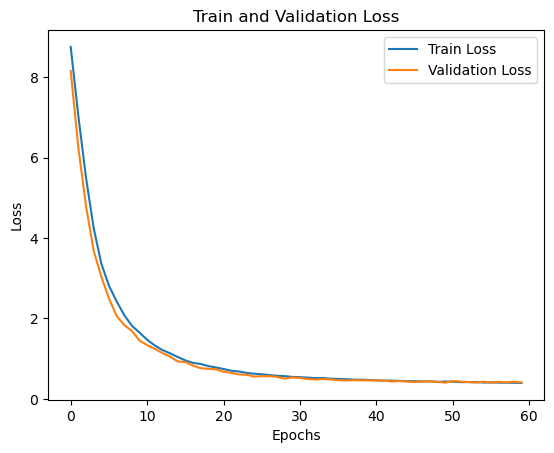

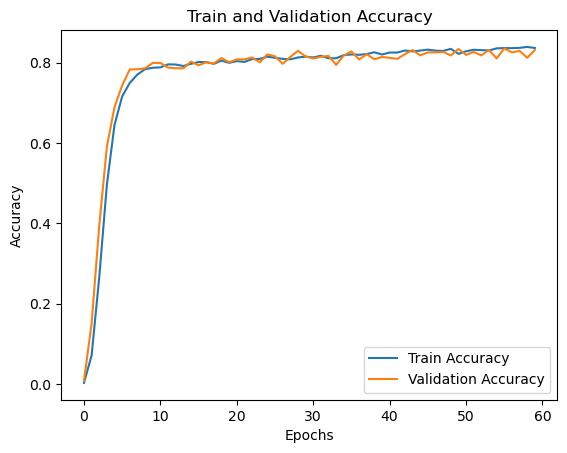

In [39]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### Confusion matrix for predictions produced


Normalized confusion matrix
[[0.81343284 0.18656716]
 [0.1618799  0.8381201 ]]


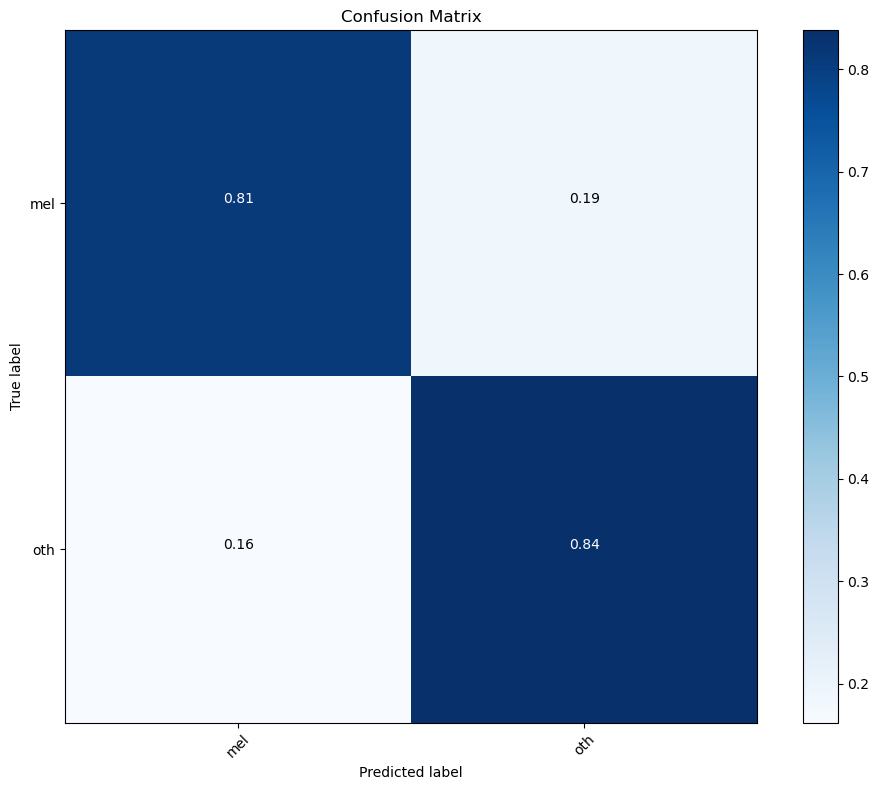

In [40]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate_model(model, val_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) # Send to gpu first then send back to cpu so numpy can do its thing
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')

# Assuming class_names is a list of class names
class_names = val_data.classes

# After training, evaluate the model on validation data
evaluate_model(model, val_loader, class_names)
